In [1]:
%load_ext autoreload
%autoreload 2


import sys
sys.path.append('../')

In [2]:
from diffusers import DDPMScheduler, StableDiffusionPipeline
from prior_models import RebecaDiffusionPrior
from sampling import  sample_user_images
import torch

/home/gapatron/anaconda3/envs/rebeca-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
config = {
    "img_embed_dim": 1024,
    "num_users": 210,
    "num_tokens": 32,
    "hidden_dim": 256,
    "num_heads": 8,
    "num_layers": 12,
    "score_classes": 2,
    "objective": "sample",
    "clip_sample": False,
    "num_timesteps": 1000,
    "noise_schedule": "squaredcos_cap_v2",
    "device": "cuda"
}
filedir = "../data/flickr/evaluation/diffusion_priors/models/weights/comprehensive_study_20250830_005452/"
filename = "modelrdp_num_layers12_num_heads8_hidden_dim256_tokens32_lr0.0001_optadamw_schreduce_on_plateau_bs64_nssquaredcos_cap_v2_ts1000_spu150_csFalse_objsample_normnone_uthr0.pth"

In [4]:
rdp = RebecaDiffusionPrior(
                img_embed_dim=1024,
                num_users=210,
                num_tokens=config["num_tokens"],
                hidden_dim=config['hidden_dim'],
                n_heads=config['num_heads'],
                num_layers=config['num_layers'],
                score_classes=2,
            ).to(config['device'])

rdp.load_state_dict(torch.load(f'{filedir}/{filename}'))

<All keys matched successfully>

## Run the generation

In [52]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(config['device'])
pipe.load_ip_adapter("h94/IP-Adapter", subfolder="models", weight_name="ip-adapter_sd15.bin")
pipe.safety_checker = None

            # Note: xformers is optional for memory efficiency
            
            # Setup noise scheduler (use the same configuration as training)
noise_scheduler = DDPMScheduler(
                num_train_timesteps=config['num_timesteps'],
                beta_schedule=config['noise_schedule'],
                clip_sample=config['clip_sample'],
                prediction_type=config["objective"]
            )

# Select users for generation (first 210 users to reduce memory usage)
users = list(range(210))
torch.manual_seed(0)
# Generate images
gen_data = sample_user_images(
                diffusion_prior_model=rdp,
                diffusion_pipe=pipe,
                users=users,
                images_per_user=10,  # Fewer images per user to save memory
                noise_scheduler=noise_scheduler,
                guidance_scale=7.5,
                prompt=[""],
                negative_prompt=[""],
                img_embedding_size=1024,
                device=config['device'],
            )

100%|██████████| 210/210 [2:57:33<00:00, 50.73s/it]


## Load the previously stored generation run

In [ ]:
gen_data = torch.load("../data/flickr/evaluation/samples/front_cover_samples_newzip.pt", weights_only=False)

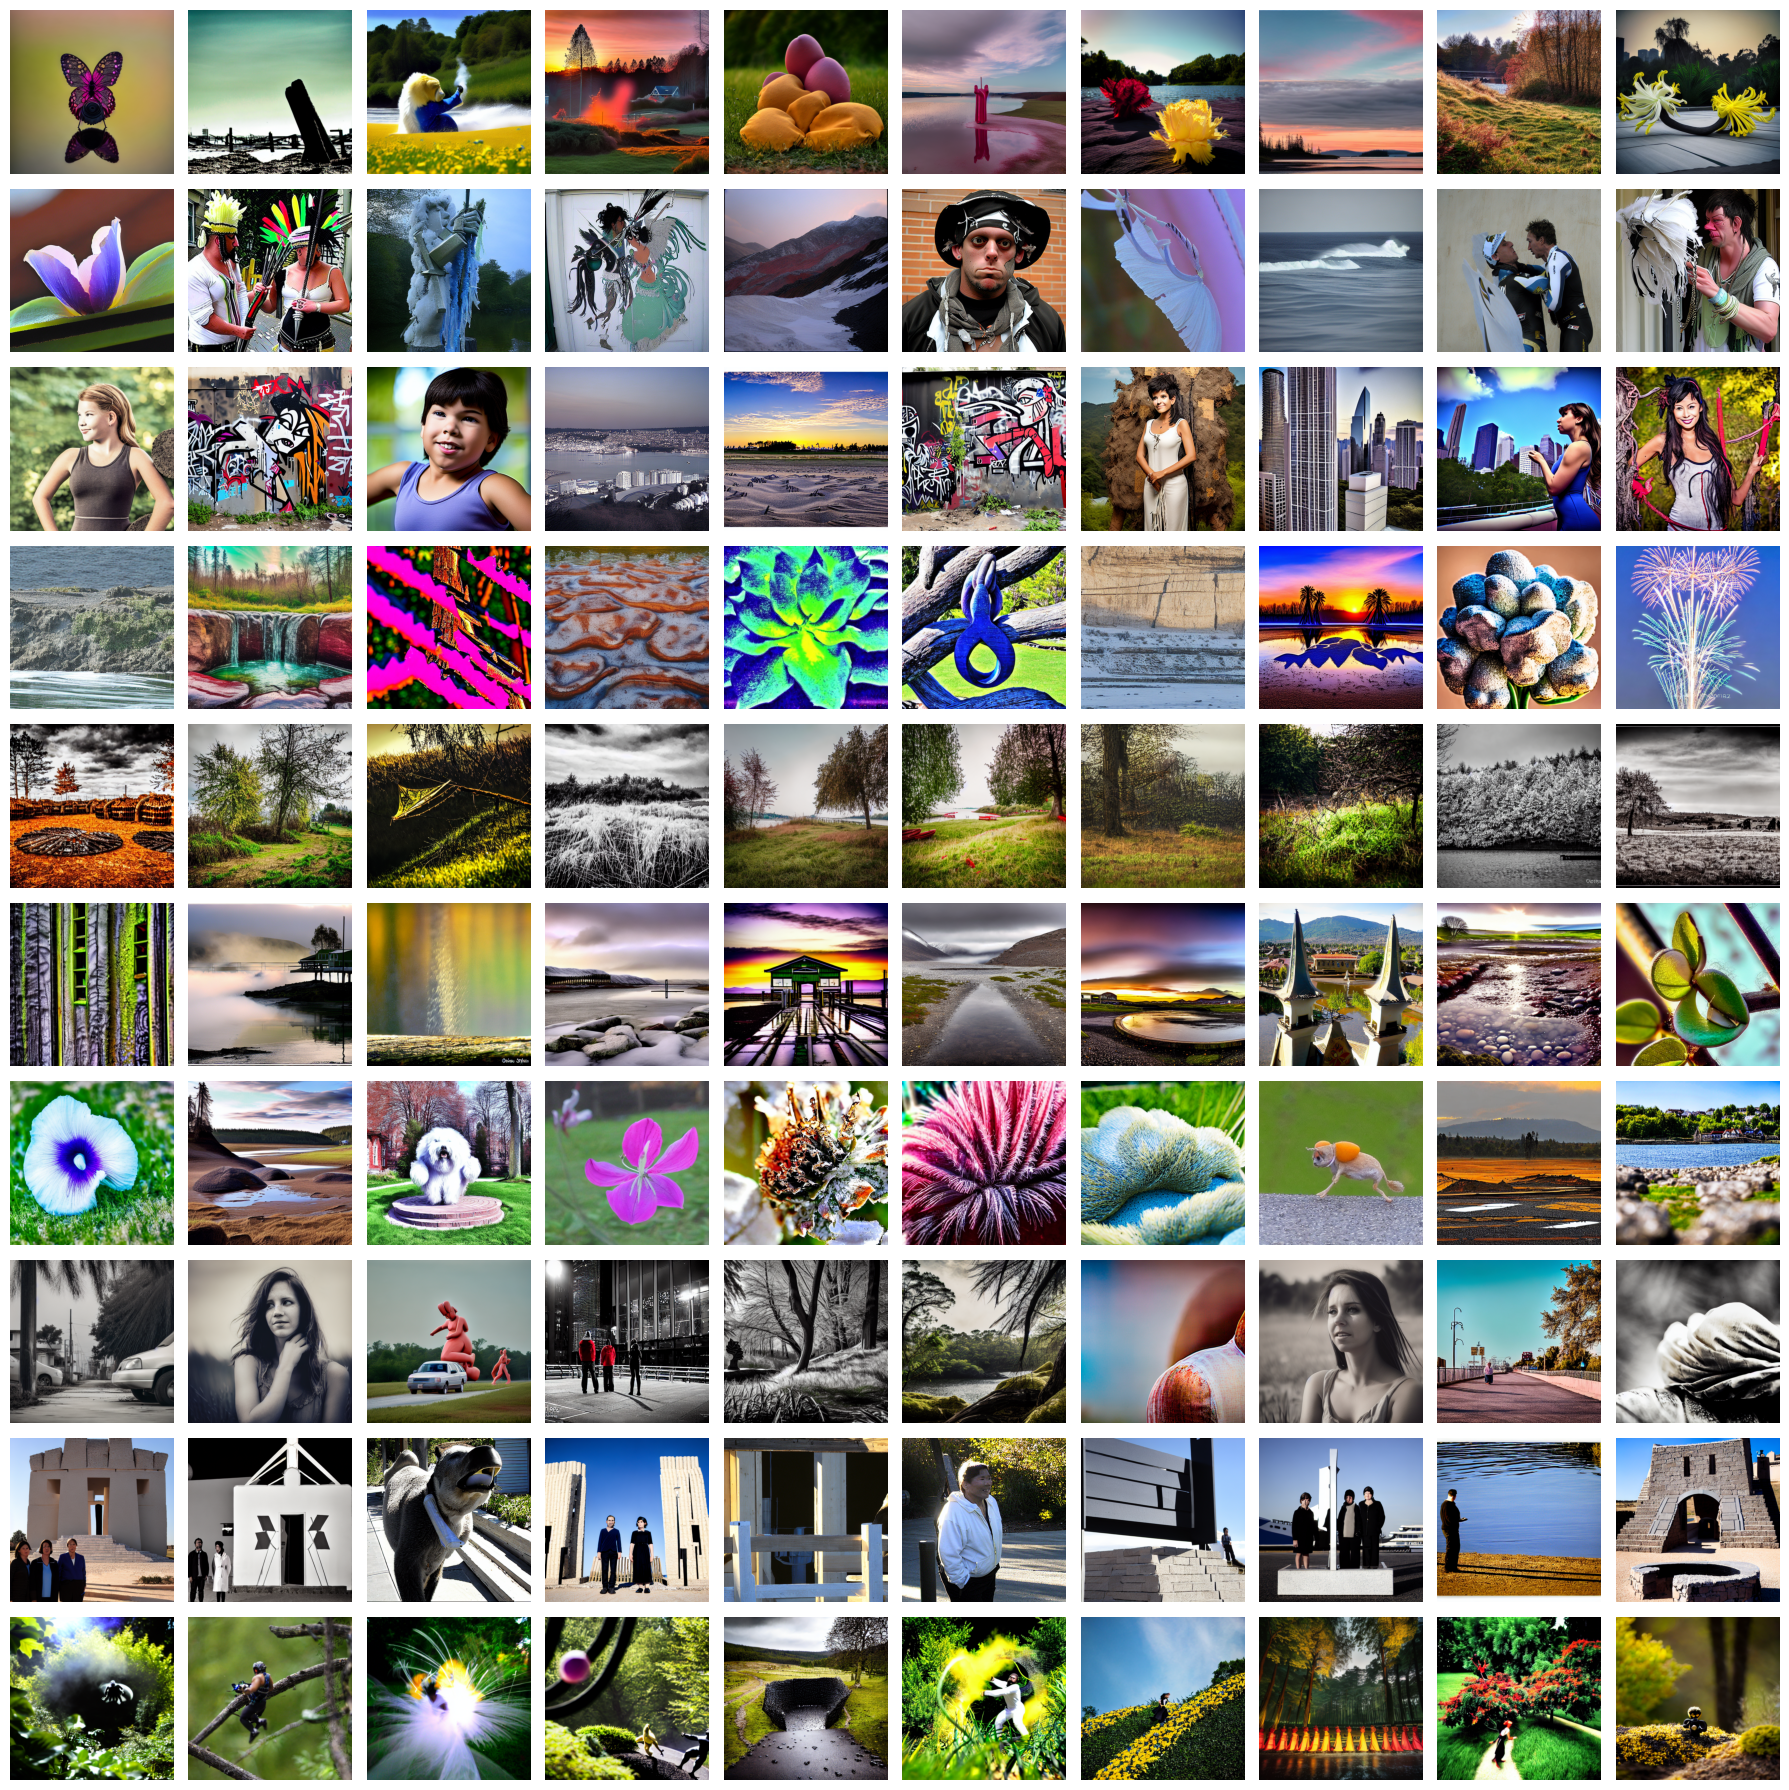

In [8]:
import matplotlib.pyplot as plt

rows = 10 # First 5 users
cols = 10 # First 10 images
figsize_per_img=(1.8, 1.8)
fig_w = max(6, cols * figsize_per_img[0])
fig_h = max(6, rows * figsize_per_img[1])
fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), squeeze=False)
for r in range(rows):
    for c in range(cols):
        ax = axes[r, c]
        ax.imshow(gen_data[r]["images"][c])
        ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
prior_embeddings_tensor = torch.cat([gen_data[i]["prior_embeddings"] for i in range(210)])

In [7]:
prior_embeddings_tensor.shape

torch.Size([2100, 1024])

In [104]:
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

umap_model = umap.UMAP(n_components=3)
X_umap = umap_model.fit_transform(prior_embeddings_tensor.numpy())

pca = PCA(n_components=3)
pca_result = pca.fit_transform(prior_embeddings_tensor.numpy())

tsne = TSNE(n_components=3, perplexity=30)
X_tsne = tsne.fit_transform(prior_embeddings_tensor.numpy())

In [105]:
import matplotlib.pyplot as plt
import numpy as np

n_per_user = 10
n_total = X_umap.shape[0]
n_users = n_total // n_per_user
user_sample_size = 15
# Repeat each user ID n_per_user times
colors = np.repeat(np.arange(n_users), n_per_user)

selected_users  = np.random.choice(range(210), size=user_sample_size, replace=False)
selected_indices = [i.item()*10 + j for i in selected_users for j in range(10)]
colors_sample = np.repeat(np.arange(user_sample_size), 10)

In [288]:
# ==== REBECA spherical plot (Option A: clear front cone) =====================
# Requirements: numpy, matplotlib, pillow. (Optional: scikit-learn, cairosvg)
import io, re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import hsv_to_rgb
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Circle
from PIL import Image

# ---------------- SVG/PNG loader (SVG via cairosvg; PNG/JPG via Pillow) -----
def _load_center_image(path, svg_px=1024):
    """
    Return an RGBA numpy array for PNG/JPG; rasterize SVG via cairosvg.
    Tries to fix common gradient refs (fill="#id" -> "url(#id)").
    """
    path = str(path)
    if path.lower().endswith(".svg"):
        try:
            import cairosvg
        except Exception:
            raise RuntimeError("cairosvg is required for SVG: pip install cairosvg")
        with open(path, "rb") as f:
            svg_bytes = f.read()
        # Fix common exporter quirk: fill="#gradientId" -> fill="url(#gradientId)"
        text = svg_bytes.decode("utf-8", errors="ignore")
        text = re.sub(
            r'(fill|stroke)\s*=\s*"#(?![0-9A-Fa-f]{3}(?:[0-9A-Fa-f]{3})?)' r'([A-Za-z_][\w\-\.:]*)"',
            r'\1="url(#\2)"',
            text,
        )
        text = re.sub(
            r'(fill|stroke)\s*:\s*#(?![0-9A-Fa-f]{3}(?:[0-9A-Fa-f]{3})?)' r'([A-Za-z_][\w\-\.:]*)',
            r'\1:url(#\2)',
            text,
        )
        try:
            png_bytes = cairosvg.svg2png(
                bytestring=text.encode("utf-8"),
                output_width=svg_px, output_height=svg_px,
                background_color=None
            )
        except Exception as e:
            raise RuntimeError(f"SVG rasterization failed: {e}")
        return np.asarray(Image.open(io.BytesIO(png_bytes)).convert("RGBA"))
    else:
        return plt.imread(path)

def add_center_image(ax, img_rgba, zoom=0.9, circle_radius=0.14):
    """Place a (square) image at center and clip it to a circle so it appears round."""
    ab = AnnotationBbox(OffsetImage(img_rgba, zoom=zoom),
                        (0.5, 0.5), xycoords='axes fraction',
                        frameon=False, zorder=10)
    clip = Circle((0.5, 0.5), circle_radius, transform=ax.transAxes, facecolor='none')
    ab.set_clip_path(clip)
    ax.add_artist(ab)

# ---------------- Projection helpers ----------------------------------------
def _inverse_stereographic(xy, scale=0.8):
    xy = np.asarray(xy, float)
    u = (xy - xy.mean(0, keepdims=True)) / (xy.std(0, keepdims=True) + 1e-8) * scale
    x, y = u[:, 0], u[:, 1]
    r2 = x*x + y*y
    d = r2 + 1.0
    S = np.stack([2*x/d, 2*y/d, (r2 - 1.0)/d], axis=1)
    return S / (np.linalg.norm(S, axis=1, keepdims=True) + 1e-12)

def _normalize_to_sphere(xyz):
    xyz = np.asarray(xyz, float)
    xyz = (xyz - xyz.mean(0, keepdims=True)) / (xyz.std(0, keepdims=True) + 1e-8)
    return xyz / (np.linalg.norm(xyz, axis=1, keepdims=True) + 1e-12)

def project_to_sphere(X):
    X = np.asarray(X)
    if X.ndim != 2 or X.shape[1] not in (2, 3):
        raise ValueError("X must be (N,2) or (N,3)")
    return _inverse_stereographic(X) if X.shape[1] == 2 else _normalize_to_sphere(X)

# ---------------- Colors & geometry helpers ---------------------------------
def lighten_rgb(rgb, amount=0.12):
    rgb = np.asarray(rgb, float)
    return np.clip((1 - amount) * rgb + amount, 0, 1)

def fit_small_circle(P, q=30):
    """
    Fit a small circle on S^2: returns center dir c (unit), tangent basis (t1,t2), angular radius alpha.
    alpha uses percentile q of angular distances for a variance-aware, tighter cap.
    """
    P = np.asarray(P, float)
    c = P.mean(0); c /= (np.linalg.norm(c) + 1e-12)
    tmp = np.array([1, 0, 0]) if abs(c[0]) < 0.9 else np.array([0, 1, 0])
    t1 = np.cross(c, tmp); t1 /= (np.linalg.norm(t1) + 1e-12)
    t2 = np.cross(c, t1);  t2 /= (np.linalg.norm(t2) + 1e-12)
    ang = np.arccos(np.clip(P @ c, -1, 1))
    alpha = float(np.percentile(ang, q))
    return c, t1, t2, alpha

def kmeans_labels(X, n_clusters, n_init=10, max_iter=200, seed=0):
    """KMeans via sklearn if available; otherwise simple NumPy fallback."""
    try:
        from sklearn.cluster import KMeans
        km = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, random_state=seed)
        return km.fit_predict(X)
    except Exception:
        rng = np.random.default_rng(seed)
        centers = X[rng.choice(len(X), n_clusters, replace=False)]
        labels = None
        for _ in range(max_iter):
            d = ((X[:, None, :] - centers[None, :, :]) ** 2).sum(-1)
            labels = d.argmin(1)
            new = np.stack([X[labels == k].mean(0) if np.any(labels == k) else centers[k]
                            for k in range(n_clusters)])
            if np.allclose(new, centers): break
            centers = new
        return labels

def _hex_to_rgb01(h):
    h = h.lstrip('#')
    return np.array([int(h[i:i+2],16) for i in (0,2,4)], float)/255.0

_TOL_BRIGHT = [
    "#4477AA","#EE6677","#228833","#CCBB44","#66CCEE","#AA3377","#BBBBBB","#000000",
]
_TOL_MUTED = [
    "#332288","#88CCEE","#44AA99","#117733","#999933","#DDCC77","#CC6677","#882255","#AA4499",
]
_KELLY_12 = [
    "#FFB300","#803E75","#FF6800","#A6BDD7","#C10020","#CEA262",
    "#817066","#007D34","#F6768E","#00538A","#FF7A5C","#53377A",
]
def make_palette(n, scheme="oklchish"):
    n = int(n)
    if n <= 0:
        return np.zeros((0,3))

    if scheme in ("tol_bright","tol_muted","kelly12"):
        base = {"tol_bright":_TOL_BRIGHT, "tol_muted":_TOL_MUTED, "kelly12":_KELLY_12}[scheme]
        base = np.vstack([_hex_to_rgb01(x) for x in base])
        if n <= len(base):
            return base[:n]
        # If you ask for more than the base has, repeat with gentle lightening
        reps = int(np.ceil(n/len(base)))
        def _lighten(c,a=0.18): return np.clip((1-a)*c + a, 0, 1)
        stack = np.vstack([base] + [_lighten(base, a) for a in np.linspace(0.06,0.22,reps-1)])
        return stack[:n]

    if scheme == "tab20x":
        base = np.vstack([np.array(cm.get_cmap("tab20").colors),
                          np.array(cm.get_cmap("tab20b").colors),
                          np.array(cm.get_cmap("tab20c").colors)])
        if n <= len(base): return base[:n]
        reps = int(np.ceil(n/len(base)))
        def _lighten(c,a=0.18): return np.clip((1-a)*np.asarray(c) + a, 0, 1)
        stack = np.vstack([base] + [_lighten(base,a) for a in np.linspace(0.08,0.28,reps-1)])
        return stack[:n]

    # defaults you already had
    h = np.linspace(0.0, 1.0, n, endpoint=False)
    if scheme == "vivid":
        s = np.full(n, 0.78); v = np.full(n, 0.96)
    elif scheme == "pastel":
        s = np.full(n, 0.35); v = np.full(n, 0.98)
    else:  # "oklchish"
        s = np.full(n, 0.70); v = 0.90 + 0.06*np.sin(2*np.pi*h*3)
    hsv = np.stack([h, s, v], 1)
    return hsv_to_rgb(hsv)

# ---------------- Main plotting function ------------------------------------
def plot_spherical_regions(
    X, user_ids,
    n_regions=12,
    first_n_users=None,
    radius=2.0, sphere_alpha=0.04, elev=18, azim=28, bg="white",
    cap_q=30, orbit_cap_deg=14, orbit_scale=1.0,
    max_caps=200, max_orbits=200,
    cap_alpha=0.22, cap_res=(12, 36), cap_front_only=False, cap_sort=True,
    orbit_alpha=0.25, orbit_lw=0.8, ring_lighten=0.08,
    draw_rays=True, max_rays=64, ray_alpha=0.35, ray_lw=1.2, ray_front_only=True,
    point_alpha=0.10, point_size=5,
    center_text="REBECA", center_image_path=None, center_image_zoom=0.95, center_circle_radius=0.14,
    figsize=(9, 9), palette_scheme="vivid",
    # --- Option A controls (front-clear cone) ---
    front_clear_deg=30,            # carve out ~30° cone in front so REBECA isn't occluded
    front_clear_use_alpha=True,    # account for cap radius when culling
):
    """
    Colors by regions (cluster of per-user centers), draws rays/caps/rings,
    and removes any users whose caps would visually block the center along
    the camera axis within a 'front_clear_deg' cone.
    """
    X = np.asarray(X); user_ids = np.asarray(user_ids)
    assert len(X) == len(user_ids)

    if first_n_users is not None:
        keepU = set(np.unique(user_ids)[:first_n_users])
        mask  = np.array([u in keepU for u in user_ids])
        X, user_ids = X[mask], user_ids[mask]

    # Project to unit sphere and scale
    S_unit = project_to_sphere(X)
    S = S_unit * radius

    # Per-user small circles
    uniq_users = np.unique(user_ids)
    per_user = []   # (uid, c, t1, t2, alpha)
    centers = []
    for uid in uniq_users:
        idx = np.where(user_ids == uid)[0]
        if idx.size < 3:
            continue
        P = S_unit[idx]
        c, t1, t2, alpha = fit_small_circle(P, q=cap_q)
        alpha = min(alpha * orbit_scale, np.deg2rad(orbit_cap_deg))
        per_user.append((uid, c, t1, t2, alpha))
        centers.append(c)
    centers = np.array(centers)
    used_users = np.array([uid for uid, _, _, _, _ in per_user])

    # Cluster centers into n_regions
    C = centers / (np.linalg.norm(centers, axis=1, keepdims=True) + 1e-12)
    region_labels = kmeans_labels(C, n_regions)
    uid2region = dict(zip(used_users, map(int, region_labels)))
    region_colors = make_palette(n_regions, scheme=palette_scheme)

    # Subsample helpers
    def subsample(uids, limit):
        if (limit is None) or (limit >= len(uids)): return uids
        step = int(np.ceil(len(uids) / limit)); return uids[::step]

    users_for_caps   = subsample(used_users, max_caps)
    users_for_orbits = subsample(used_users, max_orbits)
    users_for_rays   = subsample(used_users, max_rays)

    # View direction (toward origin)
    az, el = np.deg2rad(azim), np.deg2rad(elev)
    view_dir = -np.array([np.cos(el)*np.cos(az), np.cos(el)*np.sin(az), np.sin(el)])

    # --- Front-clear culling helper (Option A) ---
    theta0 = None if front_clear_deg is None else np.deg2rad(front_clear_deg)
    def _is_front_obstructor(dotcv, alpha_rad):
        if theta0 is None:
            return False
        thr = np.cos(theta0 + (alpha_rad if front_clear_use_alpha else 0.0))
        return dotcv > thr  # angle(c, view_dir) < theta0 (+ alpha) -> TRUE (obstructor)

    # Sort back->front for cleaner translucent caps
    if cap_sort:
        per_user.sort(key=lambda it: np.dot(it[1], view_dir))

    # Figure/axes
    from mpl_toolkits.mplot3d import Axes3D  # noqa
    fig = plt.figure(figsize=figsize, facecolor=bg)
    ax = fig.add_subplot(111, projection="3d", facecolor=bg)
    ax.set_proj_type('ortho'); ax.dist = 7.0


    # Sphere surface (subtle, no edges)
    u = np.linspace(0, np.pi, 50); v = np.linspace(0, 2*np.pi, 100)
    xs = radius*np.outer(np.sin(u), np.sin(v))
    ys = radius*np.outer(np.sin(u), np.cos(v))
    zs = radius*np.outer(np.cos(u), np.ones_like(v))
    ax.plot_surface(xs, ys, zs, rstride=3, cstride=6, linewidth=0,
                    antialiased=False, edgecolor='none', shade=False,
                    alpha=sphere_alpha, color="k")

    # Rays first
    if draw_rays:
        for uid, c, _, _, alpha in per_user:
            if uid not in users_for_rays: continue
            dotcv = float(np.dot(c, view_dir))
            if ray_front_only and (dotcv <= 0):  # keep only front if requested
                continue
            if _is_front_obstructor(dotcv, alpha):
                continue
            col = region_colors[uid2region[uid]]
            tip = radius * c
            ax.plot([0, tip[0]], [0, tip[1]], [0, tip[2]],
                    color=col, alpha=ray_alpha, linewidth=ray_lw)

    # Caps (filled interiors)
    r_steps, t_steps = cap_res
    for uid, c, t1, t2, alpha in per_user:
        if uid not in users_for_caps: continue
        dotcv = float(np.dot(c, view_dir))
        if cap_front_only and (dotcv <= 0):  # if True, only draw front hemisphere
            continue
        if _is_front_obstructor(dotcv, alpha):
            continue
        r  = np.linspace(0, alpha, r_steps); th = np.linspace(0, 2*np.pi, t_steps)
        R, TH = np.meshgrid(r, th, indexing='ij')
        cap = (np.cos(R)[:,:,None]*c + np.sin(R)[:,:,None] *
               (np.cos(TH)[:,:,None]*t1 + np.sin(TH)[:,:,None]*t2)) * radius
        col = lighten_rgb(region_colors[uid2region[uid]], 0.10)
        ax.plot_surface(cap[:,:,0], cap[:,:,1], cap[:,:,2],
                        linewidth=0, antialiased=False, edgecolor='none',
                        shade=False, color=col, alpha=cap_alpha)

    # Rings (outlines)
    t = np.linspace(0, 2*np.pi, 240)
    for uid, c, t1, t2, alpha in per_user:
        if uid not in users_for_orbits: continue
        dotcv = float(np.dot(c, view_dir))
        if cap_front_only and (dotcv <= 0):
            continue
        if _is_front_obstructor(dotcv, alpha):
            continue
        ring = (np.cos(t)[:,None]*t1 + np.sin(t)[:,None]*t2)
        ring = (np.cos(alpha)*c + np.sin(alpha)*ring) * radius
        col = lighten_rgb(region_colors[uid2region[uid]], ring_lighten)
        ax.plot(ring[:,0], ring[:,1], ring[:,2],
                color=col, linewidth=orbit_lw, alpha=orbit_alpha)

    # (Optional) Points — often better hidden for the cover
    # default_col = np.array([0.7, 0.7, 0.7])
    # cols_points = np.vstack([region_colors[uid2region[u]] if u in uid2region else default_col
    #                          for u in user_ids])
    # ax.scatter(S[:,0], S[:,1], S[:,2], s=point_size, c=cols_points, alpha=point_alpha, depthshade=False)

    # Style & camera
    ax.set_xlim(-radius, radius); ax.set_ylim(-radius, radius); ax.set_zlim(-radius, radius)
    ax.set_box_aspect((1,1,1)); ax.set_axis_off(); ax.view_init(elev=elev, azim=azim)

    # Center overlay (image or text)
    if center_image_path is not None:
        img = _load_center_image(center_image_path, svg_px=1400)
        add_center_image(ax, img, zoom=center_image_zoom, circle_radius=center_circle_radius)
    elif center_text:
        ax.text2D(0.5, 0.5, center_text, transform=ax.transAxes,
                  ha="center", va="center", fontsize=22, fontweight="bold", zorder=10)

    plt.tight_layout(); plt.show()
    return fig
# ==== END ====================================================================


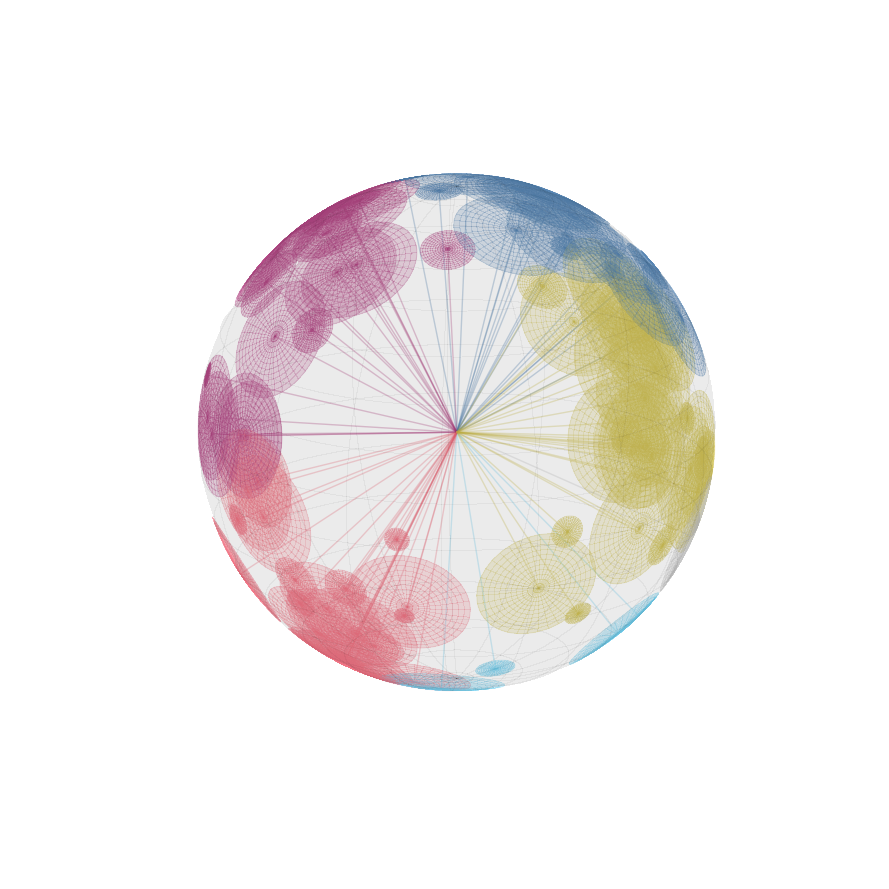

In [300]:
# Example data wiring
num_users = 210
user_ids = np.repeat(np.arange(num_users), 10)

fig = plot_spherical_regions(
    X_tsne[:num_users*10], user_ids,
    n_regions=7,
    radius=1.8,
    # Option A: clear a cone in front so REBECA isn't occluded
    cap_front_only=True,        # allow both hemispheres
    front_clear_deg=25,          # adjust 25–40° to taste
    front_clear_use_alpha=True,  # big caps culled a bit more
    # aesthetics
    cap_sort=True,
    max_caps=210, max_orbits=210, max_rays=210,
    ray_alpha=0.28, ray_lw=1.0, orbit_alpha=0.18, cap_alpha=0.20,
    palette_scheme="tol_bright",
    # center: use text or an image (SVG/PNG). If using SVG, ensure cairosvg is installed.
    center_text="",
    # center_image_path="./rebeca_final.svg",   # uncomment to use your logo
    # center_image_zoom=0.95, center_circle_radius=0.14,
)
